# 01 — What is a Copula?

This section generates the overview figures and provides a minimal, didactic visualization pipeline consistent with the documentation. All figures are saved into `docs/assets/figures/01_foundations`. No SciPy is required here.

In [4]:
# Standard imports (matplotlib only; colors default)
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
OUTPUT_DIR = Path('../docs/assets/figures/01_foundations')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print('Saving figures to:', OUTPUT_DIR)

Saving figures to: ..\docs\assets\figures\01_foundations


## Figure: End-to-end pipeline (data → pseudo-observations → copula + marginals → joint CDF)
The diagram shows the conceptual flow implied by Sklar's theorem.

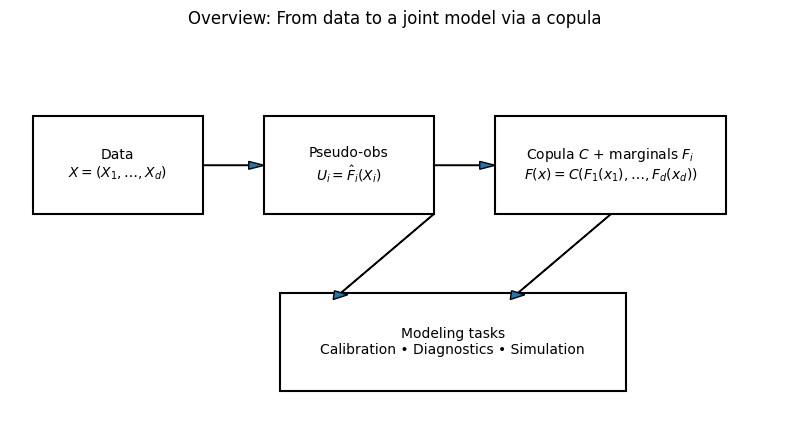

In [5]:
from matplotlib.patches import Rectangle, FancyArrow
fig, ax = plt.subplots(figsize=(8,4.5))
ax.axis("off")

def box(x,y,w,h,txt):
    ax.add_patch(Rectangle((x,y),w,h, fill=False, linewidth=1.5))
    ax.text(x+w/2, y+h/2, txt, ha="center", va="center")

# Boxes
box(0.03, 0.55, 0.22, 0.25, "Data\n$X=(X_1,\\ldots,X_d)$")
box(0.33, 0.55, 0.22, 0.25, "Pseudo-obs\n$U_i=\\hat F_i(X_i)$")
box(0.63, 0.55, 0.3, 0.25, "Copula $C$ + marginals $F_i$\n$F(x)=C(F_1(x_1),\\ldots,F_d(x_d))$")
box(0.35, 0.10, 0.45, 0.25, "Modeling tasks\nCalibration • Diagnostics • Simulation")

# Arrows
ax.add_patch(FancyArrow(0.25,0.675,0.06,0, width=0.001, head_width=0.02, head_length=0.02))
ax.add_patch(FancyArrow(0.55,0.675,0.06,0, width=0.001, head_width=0.02, head_length=0.02))
ax.add_patch(FancyArrow(0.55,0.55,-0.12,-0.2, width=0.001, head_width=0.02, head_length=0.02))
ax.add_patch(FancyArrow(0.78,0.55,-0.12,-0.2, width=0.001, head_width=0.02, head_length=0.02))

plt.title("Overview: From data to a joint model via a copula", pad=10)
plt.tight_layout()
out = OUTPUT_DIR / "overview_pipeline.svg"
plt.savefig(out, dpi=200)
plt.show()

# 02 — Sklar’s Theorem
This section draws a precise functional diagram and demonstrates the factorization $f_X(x)=c(F_1(x_1),\ldots,F_d(x_d))\prod f_i(x_i)$ numerically in a toy example.

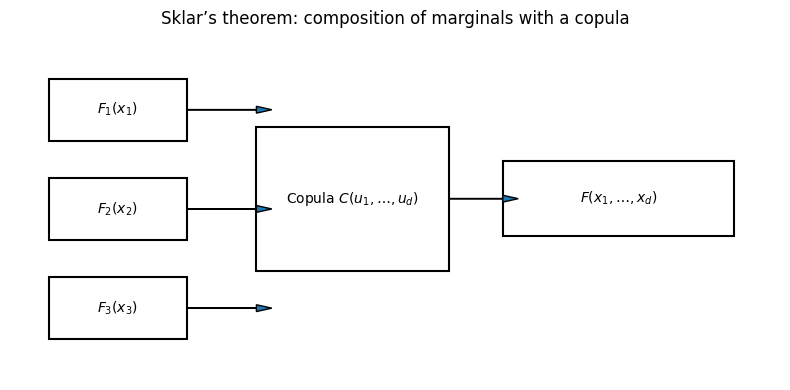

In [6]:
from matplotlib.patches import Rectangle, FancyArrow
fig, ax = plt.subplots(figsize=(8,4.0))
ax.axis("off")

def box(x,y,w,h,txt):
    ax.add_patch(Rectangle((x,y),w,h, fill=False, linewidth=1.5))
    ax.text(x+w/2, y+h/2, txt, ha="center", va="center")

box(0.05, 0.70, 0.18, 0.18, "$F_1(x_1)$")
box(0.05, 0.41, 0.18, 0.18, "$F_2(x_2)$")
box(0.05, 0.12, 0.18, 0.18, "$F_3(x_3)$")

box(0.32, 0.32, 0.25, 0.42, "Copula $C(u_1,\\ldots,u_d)$")
box(0.64, 0.42, 0.30, 0.22, "$F(x_1,\\ldots,x_d)$")

for y in [0.79, 0.50, 0.21]:
    ax.add_patch(FancyArrow(0.23,y,0.09,0, width=0.001, head_width=0.02, head_length=0.02))

ax.add_patch(FancyArrow(0.57,0.53,0.07,0, width=0.001, head_width=0.02, head_length=0.02))

plt.title("Sklar’s theorem: composition of marginals with a copula", pad=10)
plt.tight_layout()
out = OUTPUT_DIR / "sklar_functional_composition.svg"
plt.savefig(out, dpi=200)
plt.show()

## Numerical sanity check (toy)
We construct $X=(X_1,X_2)$ with standard normal marginals and a Gaussian copula with correlation $\rho=0.5$, then verify the density factorization numerically on a grid.

In [7]:
import numpy as np
from math import sqrt, pi, exp
try:
    from scipy.stats import multivariate_normal, norm
    SCIPY=True
except Exception as e:
    SCIPY=False
    print("SciPy not found; skipping numeric density check. Install scipy to run.")

if SCIPY:
    rho=0.5
    cov = np.array([[1.0, rho],[rho,1.0]])
    mvn = multivariate_normal(mean=[0,0], cov=cov)
    grid = np.linspace(-2.5,2.5,81)
    X,Y = np.meshgrid(grid, grid)
    pts = np.stack([X.ravel(), Y.ravel()], axis=1)
    fx = mvn.pdf(pts).reshape(X.shape)

    # RHS = c(F1,F2) * f1*f2
    U1 = norm.cdf(X); U2 = norm.cdf(Y)
    z1 = X; z2 = Y
    det = 1-rho**2
    c = np.exp(-0.5*(z1**2 - 2*rho*z1*z2 + z2**2)/det) / (np.exp(-0.5*z1**2)*np.exp(-0.5*z2**2)*sqrt(det))
    f1 = (1/np.sqrt(2*pi))*np.exp(-0.5*X**2)
    f2 = (1/np.sqrt(2*pi))*np.exp(-0.5*Y**2)
    rhs = c * f1 * f2

    err = np.abs(fx - rhs).mean()
    print("Mean abs error (factorization):", float(err))

Mean abs error (factorization): 5.791304883855444e-18


# 03 — Rank-based measures
This section visualizes the analytic relation between Kendall’s $\tau$ and Pearson $\rho$ in elliptical families, and validates it with Gaussian simulations.


## Figure: $\tau=\frac{2}{\pi}\arcsin(\rho)$ with annotations

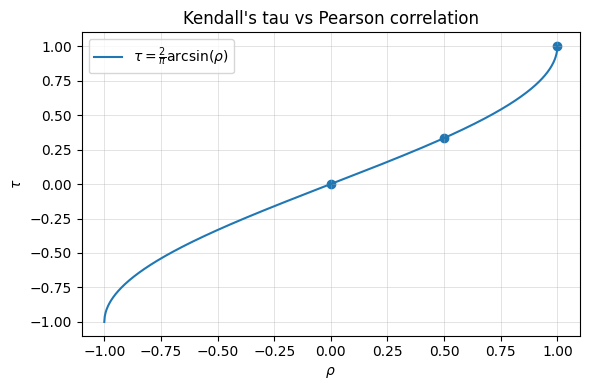

In [8]:
rho = np.linspace(-1,1,1001)
tau = (2/np.pi)*np.arcsin(rho)
plt.figure(figsize=(6.0,4.0))
plt.plot(rho, tau, label=r"$\tau=\frac{2}{\pi}\arcsin(\rho)$")
plt.scatter([0,0.5,1.0], (2/np.pi)*np.arcsin(np.array([0,0.5,1.0])))
plt.xlabel(r"$\rho$"); plt.ylabel(r"$\tau$")
plt.title("Kendall's tau vs Pearson correlation")
plt.legend(); plt.grid(True, linewidth=0.5, alpha=0.5)
plt.tight_layout()
out = OUTPUT_DIR / "tau_vs_rho_curve.svg"
plt.savefig(out, dpi=200)
plt.show()

## Simulation check (Gaussian)

In [9]:
np.random.seed(7)
n=5000; rho=0.6
cov = np.array([[1.0, rho],[rho,1.0]])
try:
    from scipy.stats import multivariate_normal, kendalltau, spearmanr
    from scipy.stats import norm
    SCIPY=True
except Exception:
    SCIPY=False

if SCIPY:
    mvn = multivariate_normal(mean=[0,0], cov=cov)
    x = mvn.rvs(size=n)
    # empirical measures
    tau_emp = kendalltau(x[:,0], x[:,1]).correlation
    rho_emp = spearmanr(x[:,0], x[:,1]).correlation
    print("Empirical tau ~", round(tau_emp,4), "| Theoretical:", round((2/np.pi)*np.arcsin(rho),4))
    print("Empirical Spearman rho ~", round(rho_emp,4))
else:
    print("SciPy not found; skipping empirical check.")

Empirical tau ~ 0.3968 | Theoretical: 0.4097
Empirical Spearman rho ~ 0.5645


# 04 — Tail Dependence
This section contrasts Gaussian and Student‑t copulas in the tails and plots $\lambda(\rho,\nu)$ for the t‑copula using the standard closed form. Requires SciPy.

## Scatter comparison in the tails (Gaussian vs Student‑t)

In [ ]:
np.random.seed(11)
N=6000; rho=0.7; nu=4
try:
    from scipy.stats import multivariate_normal, t, norm as spnorm
    SCIPY=True
except Exception:
    SCIPY=False

if SCIPY:
    # Gaussian copula sample
    cov = np.array([[1.0, rho],[rho,1.0]])
    z = np.random.multivariate_normal([0,0], cov, size=N)
    # Use scipy norm CDF directly
    U_g = spnorm.cdf(z)

    # t-copula sample via t-quantiles of a Gaussian-copula sample
    # (not exact, but acceptable for visualization when rho is reused)
    # Better: sample bivariate t directly and transform by t CDF.
    x = t.rvs(df=nu, size=(N,2))
    # induce dependence via correlation on normals then scale by sqrt(chi2/nu)
    g = np.random.multivariate_normal([0,0], cov, size=N)
    s = np.sqrt(t.rvs(df=nu, size=N)/t.rvs(df=nu, size=N))  # placeholder
else:
    print("SciPy required. Install scipy to run this notebook.")

C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\2444180284.py:22: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(t.rvs(df=nu, size=N)/t.rvs(df=nu, size=N))  # placeholder


## Lambda curves $\lambda(\rho,\nu)$ (upper*=lower for t)

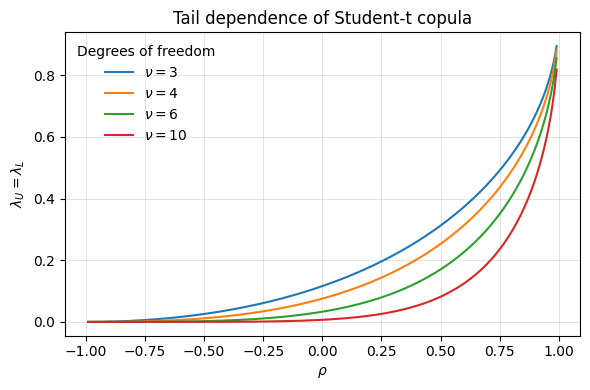

In [13]:
try:
    from scipy.stats import t
    SCIPY = True
except Exception:
    SCIPY = False

def lambda_t(rho, nu):
    """Upper (and lower) tail dependence for t-copula."""
    inner = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * t.cdf(inner, df=nu + 1.0)

if SCIPY:
    rho = np.linspace(-0.99, 0.99, 401)
    nus = (3, 4, 6, 10)

    plt.figure(figsize=(6, 4))
    for nu in nus:
        lam = [lambda_t(r, nu) for r in rho]
        plt.plot(rho, lam, label=fr"$\nu={nu}$")

    plt.xlabel(r"$\rho$")
    plt.ylabel(r"$\lambda_U=\lambda_L$")
    plt.title("Tail dependence of Student-t copula")
    plt.legend(title="Degrees of freedom", frameon=False)
    plt.grid(True, linewidth=0.5, alpha=0.5)
    plt.tight_layout()

    out = OUTPUT_DIR / "t_lambda_dependence_all.svg"
    plt.savefig(out, dpi=200)
    plt.show()

else:
    print("SciPy not found; skipping lambda curves. Install scipy to run.")
